# IT Academy - Data Science amb Python  
## Task 7: Log Transformation with Regular Expressions  
### [Github Registre de Logs](https://github.com/jesussantana/Registre_de_logs)  

[![forthebadge made-with-python](http://ForTheBadge.com/images/badges/made-with-python.svg)](https://www.python.org/)  
[![Made withJupyter](https://img.shields.io/badge/Made%20with-Jupyter-orange?style=for-the-badge&logo=Jupyter)](https://jupyter.org/try)  
[![Code Time](https://wakatime.com/badge/github/jesussantana/Registre_de_logs.svg)](https://wakatime.com/badge/github/jesussantana/Registre_de_logs) 

### Exercise 1
- Normalize, identify, and enumerate each of the attributes / variables in the "Web_access_log-akumenius.com" file structure found in the GitHub repository "Data-sources".

In [50]:
import multiprocessing
import numpy as np
import pandas as pd
import warnings
import requests
import json
import time
import re

import geopandas as gpd
import matplotlib.pyplot as plt
import plotly.express as px
import cartopy.crs as ccrs
import seaborn as sns
%matplotlib inline

from datetime import datetime
from timeit import default_timer as timer 
from joblib import Parallel, delayed
from numba import cuda
from pandas import json_normalize
from device_detector import SoftwareDetector

warnings.filterwarnings('ignore')

In [51]:
pd.set_option('display.max_columns', None)

path = 'data/Web_access_log-akumenius.com.txt'

Logs_raw = pd.read_csv(path, sep='\s | \- | \"', names =['DNS','ip','Date','Time','Request','Status','Size','Referer','UserAgent'], engine='python')

Logs_copy = Logs_raw.copy()

Logs_copy.head()

DNS                              ip  \
0  localhost 127.0.0.1  - [23/Feb/2014:03:10:31 +0100]   
1  localhost 127.0.0.1  - [23/Feb/2014:03:10:31 +0100]   
2  localhost 127.0.0.1  - [23/Feb/2014:03:10:31 +0100]   
3  localhost 127.0.0.1  - [23/Feb/2014:03:10:31 +0100]   
4  localhost 127.0.0.1  - [23/Feb/2014:03:10:31 +0100]   

                      Date Time                                     Request  \
0  OPTIONS * HTTP/1.0" 200  "-"  Apache (internal dummy connection)" VLOG=-   
1  OPTIONS * HTTP/1.0" 200  "-"  Apache (internal dummy connection)" VLOG=-   
2  OPTIONS * HTTP/1.0" 200  "-"  Apache (internal dummy connection)" VLOG=-   
3  OPTIONS * HTTP/1.0" 200  "-"  Apache (internal dummy connection)" VLOG=-   
4  OPTIONS * HTTP/1.0" 200  "-"  Apache (internal dummy connection)" VLOG=-   

  Status  Size Referer  UserAgent  
0   None  None    None        NaN  
1   None  None    None        NaN  
2   None  None    None        NaN  
3   None  None    None        NaN  
4   None  None    None        NaN

- We load the data to check how it has been distributed
  - The variables that we will use:
    - 'DNS','IP','Date','Time','Request','Status','Size','Referer','UserAgent'

###  Exercise 2
- Cleans, preprocesses, structures and transforms (dataframe) the data of the Web Access record.

- Check rows and columns

In [52]:
Logs_copy.tail()

DNS                              ip  \
261868   www.akumenius.com 5.255.253.53  - [02/Mar/2014:03:05:39 +0100]   
261869  www.akumenius.com 74.86.158.107  - [02/Mar/2014:03:09:52 +0100]   
261870              localhost 127.0.0.1  - [02/Mar/2014:03:10:18 +0100]   
261871              localhost 127.0.0.1  - [02/Mar/2014:03:10:18 +0100]   
261872              localhost 127.0.0.1  - [02/Mar/2014:03:10:18 +0100]   

                            Date Time  \
261868  GET / HTTP/1.1" 200 7528   -"   
261869      HEAD / HTTP/1.1" 200  "-"   
261870   OPTIONS * HTTP/1.0" 200  "-"   
261871   OPTIONS * HTTP/1.0" 200  "-"   
261872   OPTIONS * HTTP/1.0" 200  "-"   

                                                  Request Status  Size  \
261868  Mozilla/5.0 (compatible; YandexBot/3.0; +http:...   None  None   
261869  Mozilla/5.0+(compatible; UptimeRobot/2.0; http...   None  None   
261870         Apache (internal dummy connection)" VLOG=-   None  None   
261871         Apache (internal dummy connection)" VLOG=-   None  None   
261872         Apache (internal dummy connection)" VLOG=-   None  None   

       Referer  UserAgent  
261868    None        NaN  
261869    None        NaN  
261870    None        NaN  
261871    None        NaN  
261872    None        NaN

In [53]:
Logs_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 261873 entries, 0 to 261872
Data columns (total 9 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   DNS        261873 non-null  object 
 1   ip         261873 non-null  object 
 2   Date       261873 non-null  object 
 3   Time       261873 non-null  object 
 4   Request    261873 non-null  object 
 5   Status     486 non-null     object 
 6   Size       1 non-null       object 
 7   Referer    1 non-null       object 
 8   UserAgent  0 non-null       float64
dtypes: float64(1), object(8)
memory usage: 18.0+ MB


In [54]:
Logs_copy.shape

(261873, 9)

- Check for null data

In [55]:
Logs_copy.isnull().sum()

DNS               0
ip                0
Date              0
Time              0
Request           0
Status       261387
Size         261872
Referer      261872
UserAgent    261873
dtype: int64

In [56]:
Logs_copy.head()

DNS                              ip  \
0  localhost 127.0.0.1  - [23/Feb/2014:03:10:31 +0100]   
1  localhost 127.0.0.1  - [23/Feb/2014:03:10:31 +0100]   
2  localhost 127.0.0.1  - [23/Feb/2014:03:10:31 +0100]   
3  localhost 127.0.0.1  - [23/Feb/2014:03:10:31 +0100]   
4  localhost 127.0.0.1  - [23/Feb/2014:03:10:31 +0100]   

                      Date Time                                     Request  \
0  OPTIONS * HTTP/1.0" 200  "-"  Apache (internal dummy connection)" VLOG=-   
1  OPTIONS * HTTP/1.0" 200  "-"  Apache (internal dummy connection)" VLOG=-   
2  OPTIONS * HTTP/1.0" 200  "-"  Apache (internal dummy connection)" VLOG=-   
3  OPTIONS * HTTP/1.0" 200  "-"  Apache (internal dummy connection)" VLOG=-   
4  OPTIONS * HTTP/1.0" 200  "-"  Apache (internal dummy connection)" VLOG=-   

  Status  Size Referer  UserAgent  
0   None  None    None        NaN  
1   None  None    None        NaN  
2   None  None    None        NaN  
3   None  None    None        NaN  
4   None  None    None        NaN

In [57]:
Logs_copy.tail()

DNS                              ip  \
261868   www.akumenius.com 5.255.253.53  - [02/Mar/2014:03:05:39 +0100]   
261869  www.akumenius.com 74.86.158.107  - [02/Mar/2014:03:09:52 +0100]   
261870              localhost 127.0.0.1  - [02/Mar/2014:03:10:18 +0100]   
261871              localhost 127.0.0.1  - [02/Mar/2014:03:10:18 +0100]   
261872              localhost 127.0.0.1  - [02/Mar/2014:03:10:18 +0100]   

                            Date Time  \
261868  GET / HTTP/1.1" 200 7528   -"   
261869      HEAD / HTTP/1.1" 200  "-"   
261870   OPTIONS * HTTP/1.0" 200  "-"   
261871   OPTIONS * HTTP/1.0" 200  "-"   
261872   OPTIONS * HTTP/1.0" 200  "-"   

                                                  Request Status  Size  \
261868  Mozilla/5.0 (compatible; YandexBot/3.0; +http:...   None  None   
261869  Mozilla/5.0+(compatible; UptimeRobot/2.0; http...   None  None   
261870         Apache (internal dummy connection)" VLOG=-   None  None   
261871         Apache (internal dummy connection)" VLOG=-   None  None   
261872         Apache (internal dummy connection)" VLOG=-   None  None   

       Referer  UserAgent  
261868    None        NaN  
261869    None        NaN  
261870    None        NaN  
261871    None        NaN  
261872    None        NaN

- Reorder columns of data

In [58]:
Logs_copy.UserAgent = Logs_copy.Request
Logs_copy.Request = Logs_copy.Date
Logs_copy.Referer = Logs_copy.Time
Logs_copy.Date = Logs_copy.ip
Logs_copy.Time = Logs_copy.ip = None

Logs_copy.head()

DNS    ip                            Date  Time  \
0  localhost 127.0.0.1  None  - [23/Feb/2014:03:10:31 +0100]  None   
1  localhost 127.0.0.1  None  - [23/Feb/2014:03:10:31 +0100]  None   
2  localhost 127.0.0.1  None  - [23/Feb/2014:03:10:31 +0100]  None   
3  localhost 127.0.0.1  None  - [23/Feb/2014:03:10:31 +0100]  None   
4  localhost 127.0.0.1  None  - [23/Feb/2014:03:10:31 +0100]  None   

                   Request Status  Size Referer  \
0  OPTIONS * HTTP/1.0" 200   None  None     "-"   
1  OPTIONS * HTTP/1.0" 200   None  None     "-"   
2  OPTIONS * HTTP/1.0" 200   None  None     "-"   
3  OPTIONS * HTTP/1.0" 200   None  None     "-"   
4  OPTIONS * HTTP/1.0" 200   None  None     "-"   

                                    UserAgent  
0  Apache (internal dummy connection)" VLOG=-  
1  Apache (internal dummy connection)" VLOG=-  
2  Apache (internal dummy connection)" VLOG=-  
3  Apache (internal dummy connection)" VLOG=-  
4  Apache (internal dummy connection)" VLOG=-

- DNS & IP data split

In [59]:
Logs_copy[['DNS','ip']] = Logs_copy.DNS.str.split('\s', expand = True).get([0, 1])

In [60]:
Logs_copy.head()

DNS         ip                            Date  Time  \
0  localhost  127.0.0.1  - [23/Feb/2014:03:10:31 +0100]  None   
1  localhost  127.0.0.1  - [23/Feb/2014:03:10:31 +0100]  None   
2  localhost  127.0.0.1  - [23/Feb/2014:03:10:31 +0100]  None   
3  localhost  127.0.0.1  - [23/Feb/2014:03:10:31 +0100]  None   
4  localhost  127.0.0.1  - [23/Feb/2014:03:10:31 +0100]  None   

                   Request Status  Size Referer  \
0  OPTIONS * HTTP/1.0" 200   None  None     "-"   
1  OPTIONS * HTTP/1.0" 200   None  None     "-"   
2  OPTIONS * HTTP/1.0" 200   None  None     "-"   
3  OPTIONS * HTTP/1.0" 200   None  None     "-"   
4  OPTIONS * HTTP/1.0" 200   None  None     "-"   

                                    UserAgent  
0  Apache (internal dummy connection)" VLOG=-  
1  Apache (internal dummy connection)" VLOG=-  
2  Apache (internal dummy connection)" VLOG=-  
3  Apache (internal dummy connection)" VLOG=-  
4  Apache (internal dummy connection)" VLOG=-

- Check how many different DNS & Ips exist

In [61]:
Logs_copy.DNS.unique()

array(['localhost', 'www.akumenius.com', 'akumenius.com', 'akumenius.es',
       'test.akumenius.com'], dtype=object)

In [62]:
len(Logs_copy.ip.unique())

2921

- Normalize DNS

In [63]:
String_pattern = "^[aeiouAEIOU]{1}[A-Za-z]*"
Logs_copy.DNS = Logs_copy.DNS.apply(lambda x: (('www.{}'.format(x)) if re.search(String_pattern, x) else x))

In [64]:
Logs_copy.DNS.unique()

array(['localhost', 'www.akumenius.com', 'www.akumenius.es',
       'test.akumenius.com'], dtype=object)

- Time data extraction

In [65]:
Logs_copy.Time =pd.to_datetime(Logs_copy.Time,format='%d/%b/%Y:%H:%M:%S %z',errors='ignore')


Logs_copy.head()

DNS         ip                            Date Time  \
0  localhost  127.0.0.1  - [23/Feb/2014:03:10:31 +0100]  NaT   
1  localhost  127.0.0.1  - [23/Feb/2014:03:10:31 +0100]  NaT   
2  localhost  127.0.0.1  - [23/Feb/2014:03:10:31 +0100]  NaT   
3  localhost  127.0.0.1  - [23/Feb/2014:03:10:31 +0100]  NaT   
4  localhost  127.0.0.1  - [23/Feb/2014:03:10:31 +0100]  NaT   

                   Request Status  Size Referer  \
0  OPTIONS * HTTP/1.0" 200   None  None     "-"   
1  OPTIONS * HTTP/1.0" 200   None  None     "-"   
2  OPTIONS * HTTP/1.0" 200   None  None     "-"   
3  OPTIONS * HTTP/1.0" 200   None  None     "-"   
4  OPTIONS * HTTP/1.0" 200   None  None     "-"   

                                    UserAgent  
0  Apache (internal dummy connection)" VLOG=-  
1  Apache (internal dummy connection)" VLOG=-  
2  Apache (internal dummy connection)" VLOG=-  
3  Apache (internal dummy connection)" VLOG=-  
4  Apache (internal dummy connection)" VLOG=-

In [66]:
Logs_copy.Time = Logs_copy.Date.str.extract(':(\d{2}:\d{2}:\d{2}.*)]')
Logs_copy.head()

DNS         ip                            Date            Time  \
0  localhost  127.0.0.1  - [23/Feb/2014:03:10:31 +0100]  03:10:31 +0100   
1  localhost  127.0.0.1  - [23/Feb/2014:03:10:31 +0100]  03:10:31 +0100   
2  localhost  127.0.0.1  - [23/Feb/2014:03:10:31 +0100]  03:10:31 +0100   
3  localhost  127.0.0.1  - [23/Feb/2014:03:10:31 +0100]  03:10:31 +0100   
4  localhost  127.0.0.1  - [23/Feb/2014:03:10:31 +0100]  03:10:31 +0100   

                   Request Status  Size Referer  \
0  OPTIONS * HTTP/1.0" 200   None  None     "-"   
1  OPTIONS * HTTP/1.0" 200   None  None     "-"   
2  OPTIONS * HTTP/1.0" 200   None  None     "-"   
3  OPTIONS * HTTP/1.0" 200   None  None     "-"   
4  OPTIONS * HTTP/1.0" 200   None  None     "-"   

                                    UserAgent  
0  Apache (internal dummy connection)" VLOG=-  
1  Apache (internal dummy connection)" VLOG=-  
2  Apache (internal dummy connection)" VLOG=-  
3  Apache (internal dummy connection)" VLOG=-  
4  Apache (internal dummy connection)" VLOG=-

- Date data extraction

In [67]:
Logs_copy.Date = Logs_copy.Date.str.extract('(\d+/\w+/\d+)')

Logs_copy.Date = pd.to_datetime(Logs_copy.Date, format = '%d/%b/%Y')

In [69]:
Logs_copy.head()

DNS         ip       Date            Time                  Request  \
0  localhost  127.0.0.1 2014-02-23  03:10:31 +0100  OPTIONS * HTTP/1.0" 200   
1  localhost  127.0.0.1 2014-02-23  03:10:31 +0100  OPTIONS * HTTP/1.0" 200   
2  localhost  127.0.0.1 2014-02-23  03:10:31 +0100  OPTIONS * HTTP/1.0" 200   
3  localhost  127.0.0.1 2014-02-23  03:10:31 +0100  OPTIONS * HTTP/1.0" 200   
4  localhost  127.0.0.1 2014-02-23  03:10:31 +0100  OPTIONS * HTTP/1.0" 200   

  Status  Size Referer                                   UserAgent  
0   None  None     "-"  Apache (internal dummy connection)" VLOG=-  
1   None  None     "-"  Apache (internal dummy connection)" VLOG=-  
2   None  None     "-"  Apache (internal dummy connection)" VLOG=-  
3   None  None     "-"  Apache (internal dummy connection)" VLOG=-  
4   None  None     "-"  Apache (internal dummy connection)" VLOG=-

- Request & Status data split

In [71]:
Logs_copy[['Request','Status']] = Logs_copy.Request.str.split('\"', expand = True).get([0, 1])

In [73]:
Logs_copy.tail()

DNS             ip       Date            Time  \
261868  www.akumenius.com   5.255.253.53 2014-03-02  03:05:39 +0100   
261869  www.akumenius.com  74.86.158.107 2014-03-02  03:09:52 +0100   
261870          localhost      127.0.0.1 2014-03-02  03:10:18 +0100   
261871          localhost      127.0.0.1 2014-03-02  03:10:18 +0100   
261872          localhost      127.0.0.1 2014-03-02  03:10:18 +0100   

                   Request     Status  Size Referer  \
261868      GET / HTTP/1.1   200 7528  None      -"   
261869     HEAD / HTTP/1.1        200  None     "-"   
261870  OPTIONS * HTTP/1.0        200  None     "-"   
261871  OPTIONS * HTTP/1.0        200  None     "-"   
261872  OPTIONS * HTTP/1.0        200  None     "-"   

                                                UserAgent  
261868  Mozilla/5.0 (compatible; YandexBot/3.0; +http:...  
261869  Mozilla/5.0+(compatible; UptimeRobot/2.0; http...  
261870         Apache (internal dummy connection)" VLOG=-  
261871         Apache (internal dummy connection)" VLOG=-  
261872         Apache (internal dummy connection)" VLOG=-

In [75]:
Logs_copy.head()

DNS         ip       Date            Time             Request Status  \
0  localhost  127.0.0.1 2014-02-23  03:10:31 +0100  OPTIONS * HTTP/1.0    200   
1  localhost  127.0.0.1 2014-02-23  03:10:31 +0100  OPTIONS * HTTP/1.0    200   
2  localhost  127.0.0.1 2014-02-23  03:10:31 +0100  OPTIONS * HTTP/1.0    200   
3  localhost  127.0.0.1 2014-02-23  03:10:31 +0100  OPTIONS * HTTP/1.0    200   
4  localhost  127.0.0.1 2014-02-23  03:10:31 +0100  OPTIONS * HTTP/1.0    200   

   Size Referer                                   UserAgent  
0  None     "-"  Apache (internal dummy connection)" VLOG=-  
1  None     "-"  Apache (internal dummy connection)" VLOG=-  
2  None     "-"  Apache (internal dummy connection)" VLOG=-  
3  None     "-"  Apache (internal dummy connection)" VLOG=-  
4  None     "-"  Apache (internal dummy connection)" VLOG=-

- Size data extraction

In [77]:
Logs_copy.Size = Logs_copy.Status.str.extract('(\d+$)')
Logs_copy

DNS             ip       Date            Time  \
0               localhost      127.0.0.1 2014-02-23  03:10:31 +0100   
1               localhost      127.0.0.1 2014-02-23  03:10:31 +0100   
2               localhost      127.0.0.1 2014-02-23  03:10:31 +0100   
3               localhost      127.0.0.1 2014-02-23  03:10:31 +0100   
4               localhost      127.0.0.1 2014-02-23  03:10:31 +0100   
...                   ...            ...        ...             ...   
261868  www.akumenius.com   5.255.253.53 2014-03-02  03:05:39 +0100   
261869  www.akumenius.com  74.86.158.107 2014-03-02  03:09:52 +0100   
261870          localhost      127.0.0.1 2014-03-02  03:10:18 +0100   
261871          localhost      127.0.0.1 2014-03-02  03:10:18 +0100   
261872          localhost      127.0.0.1 2014-03-02  03:10:18 +0100   

                   Request     Status  Size Referer  \
0       OPTIONS * HTTP/1.0        200   200     "-"   
1       OPTIONS * HTTP/1.0        200   200     "-"   
2       OPTIONS * HTTP/1.0        200   200     "-"   
3       OPTIONS * HTTP/1.0        200   200     "-"   
4       OPTIONS * HTTP/1.0        200   200     "-"   
...                    ...        ...   ...     ...   
261868      GET / HTTP/1.1   200 7528  7528      -"   
261869     HEAD / HTTP/1.1        200   200     "-"   
261870  OPTIONS * HTTP/1.0        200   200     "-"   
261871  OPTIONS * HTTP/1.0        200   200     "-"   
261872  OPTIONS * HTTP/1.0        200   200     "-"   

                                                UserAgent  
0              Apache (internal dummy connection)" VLOG=-  
1              Apache (internal dummy connection)" VLOG=-  
2              Apache (internal dummy connection)" VLOG=-  
3              Apache (internal dummy connection)" VLOG=-  
4              Apache (internal dummy connection)" VLOG=-  
...                                                   ...  
261868  Mozilla/5.0 (compatible; YandexBot/3.0; +http:...  
261869  Mozilla/5.0+(compatible; UptimeRobot/2.0; http...  
261870         Apache (internal dummy connection)" VLOG=-  
261871         Apache (internal dummy connection)" VLOG=-  
261872         Apache (internal dummy connection)" VLOG=-  

[261873 rows x 9 columns]

- Clean Size data

In [79]:
%%time

Logs_copy.Size = Logs_copy.Size.apply(lambda x: (np.nan if x == '200' else x))

CPU times: user 73.9 ms, sys: 98 µs, total: 74 ms
Wall time: 72.9 ms


In [81]:
Logs_copy

DNS             ip       Date            Time  \
0               localhost      127.0.0.1 2014-02-23  03:10:31 +0100   
1               localhost      127.0.0.1 2014-02-23  03:10:31 +0100   
2               localhost      127.0.0.1 2014-02-23  03:10:31 +0100   
3               localhost      127.0.0.1 2014-02-23  03:10:31 +0100   
4               localhost      127.0.0.1 2014-02-23  03:10:31 +0100   
...                   ...            ...        ...             ...   
261868  www.akumenius.com   5.255.253.53 2014-03-02  03:05:39 +0100   
261869  www.akumenius.com  74.86.158.107 2014-03-02  03:09:52 +0100   
261870          localhost      127.0.0.1 2014-03-02  03:10:18 +0100   
261871          localhost      127.0.0.1 2014-03-02  03:10:18 +0100   
261872          localhost      127.0.0.1 2014-03-02  03:10:18 +0100   

                   Request     Status  Size Referer  \
0       OPTIONS * HTTP/1.0        200   NaN     "-"   
1       OPTIONS * HTTP/1.0        200   NaN     "-"   
2       OPTIONS * HTTP/1.0        200   NaN     "-"   
3       OPTIONS * HTTP/1.0        200   NaN     "-"   
4       OPTIONS * HTTP/1.0        200   NaN     "-"   
...                    ...        ...   ...     ...   
261868      GET / HTTP/1.1   200 7528  7528      -"   
261869     HEAD / HTTP/1.1        200   NaN     "-"   
261870  OPTIONS * HTTP/1.0        200   NaN     "-"   
261871  OPTIONS * HTTP/1.0        200   NaN     "-"   
261872  OPTIONS * HTTP/1.0        200   NaN     "-"   

                                                UserAgent  
0              Apache (internal dummy connection)" VLOG=-  
1              Apache (internal dummy connection)" VLOG=-  
2              Apache (internal dummy connection)" VLOG=-  
3              Apache (internal dummy connection)" VLOG=-  
4              Apache (internal dummy connection)" VLOG=-  
...                                                   ...  
261868  Mozilla/5.0 (compatible; YandexBot/3.0; +http:...  
261869  Mozilla/5.0+(compatible; UptimeRobot/2.0; http...  
261870         Apache (internal dummy connection)" VLOG=-  
261871         Apache (internal dummy connection)" VLOG=-  
261872         Apache (internal dummy connection)" VLOG=-  

[261873 rows x 9 columns]

- Status data extraction

In [83]:
Logs_copy.Status = Logs_copy.Status.str.extract('(\d{3})')
Logs_copy.tail()

DNS             ip       Date            Time  \
261868  www.akumenius.com   5.255.253.53 2014-03-02  03:05:39 +0100   
261869  www.akumenius.com  74.86.158.107 2014-03-02  03:09:52 +0100   
261870          localhost      127.0.0.1 2014-03-02  03:10:18 +0100   
261871          localhost      127.0.0.1 2014-03-02  03:10:18 +0100   
261872          localhost      127.0.0.1 2014-03-02  03:10:18 +0100   

                   Request Status  Size Referer  \
261868      GET / HTTP/1.1    200  7528      -"   
261869     HEAD / HTTP/1.1    200   NaN     "-"   
261870  OPTIONS * HTTP/1.0    200   NaN     "-"   
261871  OPTIONS * HTTP/1.0    200   NaN     "-"   
261872  OPTIONS * HTTP/1.0    200   NaN     "-"   

                                                UserAgent  
261868  Mozilla/5.0 (compatible; YandexBot/3.0; +http:...  
261869  Mozilla/5.0+(compatible; UptimeRobot/2.0; http...  
261870         Apache (internal dummy connection)" VLOG=-  
261871         Apache (internal dummy connection)" VLOG=-  
261872         Apache (internal dummy connection)" VLOG=-

- Clean Referer data

In [85]:
%%time
Logs_copy.Referer = Logs_copy.Referer.astype(str)
Logs_copy.Referer = Logs_copy.Referer.apply(lambda x: (np.nan if re.search('-"', x) else x.rstrip('-"')))

CPU times: user 300 ms, sys: 3.52 ms, total: 303 ms
Wall time: 302 ms


In [87]:
Logs_copy.Referer.unique()

array([nan,
       'http://www.akumenius.com/hoteles-baratos/ofertas-hotel-Playa-Blanca-All-Inclusive-en-Cayo%20Largo_CUBA-62359b.html',
       'http://www.akumenius.com/', ...,
       '"http://www.akumenius.com/booking/152186/t/BARCELO%20DOMINICAN%20BEACH/4',
       'http://www.akumenius.com/hotelDetailPopup/49612/b',
       'http://www.akumenius.com/destinos-baratos/destinos-caracteristicas/hoteles-baratos-en-Phuket_TAILANDIA-con-Windsurf'],
      dtype=object)

In [89]:
Logs_copy

DNS             ip       Date            Time  \
0               localhost      127.0.0.1 2014-02-23  03:10:31 +0100   
1               localhost      127.0.0.1 2014-02-23  03:10:31 +0100   
2               localhost      127.0.0.1 2014-02-23  03:10:31 +0100   
3               localhost      127.0.0.1 2014-02-23  03:10:31 +0100   
4               localhost      127.0.0.1 2014-02-23  03:10:31 +0100   
...                   ...            ...        ...             ...   
261868  www.akumenius.com   5.255.253.53 2014-03-02  03:05:39 +0100   
261869  www.akumenius.com  74.86.158.107 2014-03-02  03:09:52 +0100   
261870          localhost      127.0.0.1 2014-03-02  03:10:18 +0100   
261871          localhost      127.0.0.1 2014-03-02  03:10:18 +0100   
261872          localhost      127.0.0.1 2014-03-02  03:10:18 +0100   

                   Request Status  Size Referer  \
0       OPTIONS * HTTP/1.0    200   NaN     NaN   
1       OPTIONS * HTTP/1.0    200   NaN     NaN   
2       OPTIONS * HTTP/1.0    200   NaN     NaN   
3       OPTIONS * HTTP/1.0    200   NaN     NaN   
4       OPTIONS * HTTP/1.0    200   NaN     NaN   
...                    ...    ...   ...     ...   
261868      GET / HTTP/1.1    200  7528     NaN   
261869     HEAD / HTTP/1.1    200   NaN     NaN   
261870  OPTIONS * HTTP/1.0    200   NaN     NaN   
261871  OPTIONS * HTTP/1.0    200   NaN     NaN   
261872  OPTIONS * HTTP/1.0    200   NaN     NaN   

                                                UserAgent  
0              Apache (internal dummy connection)" VLOG=-  
1              Apache (internal dummy connection)" VLOG=-  
2              Apache (internal dummy connection)" VLOG=-  
3              Apache (internal dummy connection)" VLOG=-  
4              Apache (internal dummy connection)" VLOG=-  
...                                                   ...  
261868  Mozilla/5.0 (compatible; YandexBot/3.0; +http:...  
261869  Mozilla/5.0+(compatible; UptimeRobot/2.0; http...  
261870         Apache (internal dummy connection)" VLOG=-  
261871         Apache (internal dummy connection)" VLOG=-  
261872         Apache (internal dummy connection)" VLOG=-  

[261873 rows x 9 columns]

###  Exercise 3
- Geolocates IP's. Here is a page of interest:
  - [freegeoip](https://freegeoip.app/)

- We export Ips file for security

In [91]:
Ips_export= Logs_copy.ip.copy()

Ips_export.replace('', 'null', inplace = True)

Ips_export.to_csv('../../Data/Ips_export.csv', index = False)

- Ips file recovery

In [93]:
path = '../../Data/Ips_export.csv'

Ips_raw = pd.read_csv(path, sep= 'delimiter', engine='python')

Ips_raw.head()

ip
0  127.0.0.1
1  127.0.0.1
2  127.0.0.1
3  127.0.0.1
4  127.0.0.1

In [95]:
Ips_raw.tail()

ip
261868   5.255.253.53
261869  74.86.158.107
261870      127.0.0.1
261871      127.0.0.1
261872      127.0.0.1

- Make a copy of the data to be used and we check them

In [97]:
ips_unique = pd.DataFrame({"ip": Ips_raw.ip.unique()})

In [99]:
len(ips_unique)

2921

In [101]:
ips_unique

ip
0           127.0.0.1
1       66.249.76.216
2        5.255.253.53
3       157.55.35.112
4     193.111.141.116
...               ...
2916    46.222.83.180
2917    79.155.78.117
2918  217.174.248.179
2919   188.135.173.80
2920     206.198.5.33

[2921 rows x 1 columns]

In [103]:
url = "https://freegeoip.app/json/"
localhost = "127.0.0.1"
local = {'ip': '127.0.0.1',
 'country_code': 'ES',
 'country_name': 'Spain',
 'region_code': 'GI',
 'region_name': 'Girona',
 'city': 'Girona',
 'zip_code': '17003',
 'time_zone': 'Europe/Madrid',
 'latitude': 41.9831,
 'longitude': 	2.8249,
 'metro_code': 0}

- Function for extract Information freegeoip

In [105]:
def extract_info(ip):
    if ip != localhost:
        try:
            response = requests.get(url+ip)
            if response.status_code == 200:
                return response.json()
        except TypeError:
            pass       
    else:
        return local

- Function optimized to run on GPU 

In [107]:
@cuda.jit(target ="cuda")
def extract_info_cuda(ip):
    if ip != localhost:
        try:
            response = requests.get(url+ip)
            if response.status_code == 200:
                return response.json()
        except TypeError:
            pass       
    else:
        return local

- Ips Information Extraction

In [68]:
%%time

geolocations = {}

geolocations = (Parallel(n_jobs = 8, backend = "multiprocessing")(map(delayed(extract_info), ips_unique.ip)))

CPU times: user 1.43 s, sys: 425 ms, total: 1.86 s
Wall time: 1min 11s


- joblib.Parallel uses the backend module to start worker processes, executing tasks simultaneously on separate CPUs.
- It takes about 1 minute to extract the data from the 2921 IPS, much faster when using 4 cores and 8 threads

- Run on GPU

In [ ]:
if __name__=="__main__":

    geolocations = {}
    start = timer()
    geolocations = (Parallel(n_jobs = 8, backend = "multiprocessing")(map(delayed(extract_info), ips_unique.ip)))
    print("with GPU:", timer()-start)  

- Check the Data obtained

In [70]:
len(geolocations)

2921

In [72]:
type(geolocations)

list

In [74]:
geolocations[1]

{'ip': '66.249.76.216',
 'country_code': 'US',
 'country_name': 'United States',
 'region_code': '',
 'region_name': '',
 'city': '',
 'zip_code': '',
 'time_zone': 'America/Chicago',
 'latitude': 37.751,
 'longitude': -97.822,
 'metro_code': 0}

- Convert to Dataframe

In [76]:
geolocation_df = pd.DataFrame(geolocations)

In [78]:
geolocation_df

ip country_code    country_name region_code  \
0           127.0.0.1           ES           Spain          GI   
1       66.249.76.216           US   United States               
2        5.255.253.53           RU          Russia         MOW   
3       157.55.35.112           US   United States          WA   
4     193.111.141.116           DE         Germany          NW   
...               ...          ...             ...         ...   
2916    46.222.83.180           ES           Spain          MD   
2917    79.155.78.117           ES           Spain          CN   
2918  217.174.248.179           GB  United Kingdom               
2919   188.135.173.80           IT           Italy               
2920     206.198.5.33           US   United States          IL   

                 region_name                        city zip_code  \
0                     Girona                      Girona    17003   
1                                                                   
2                     Moscow                      Moscow   125009   
3                 Washington                                        
4     North Rhine-Westphalia                  Düsseldorf    40472   
...                      ...                         ...      ...   
2916                  Madrid                      Madrid    28034   
2917          Canary Islands  San Cristóbal de La Laguna    38207   
2918                                                                
2919                                                                
2920                Illinois                                        

                time_zone  latitude  longitude  metro_code  
0           Europe/Madrid   41.9831     2.8249           0  
1         America/Chicago   37.7510   -97.8220           0  
2           Europe/Moscow   55.7527    37.6172           0  
3     America/Los_Angeles   47.6032  -122.3412           0  
4           Europe/Berlin   51.2705     6.8144           0  
...                   ...       ...        ...         ...  
2916        Europe/Madrid   40.4143    -3.7016           0  
2917      Atlantic/Canary   28.4853   -16.3201           0  
2918        Europe/London   51.4964    -0.1224           0  
2919          Europe/Rome   43.1479    12.1097           0  
2920      America/Chicago   41.8483   -87.6517           0  

[2921 rows x 11 columns]

- Export Geolocations to JSON File

In [80]:
geolocation_df_export = geolocation_df.copy()
geolocation_df_export.to_json('data/geolocation.json', orient="records")

-  Export Geolocations to CSV File

In [82]:
geolocation_df_export = geolocation_df.copy()

geolocation_df_export.replace('', 'null', inplace = True)

geolocation_df_export.to_json('data/geolocation.csv')

In [84]:
geolocation_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2921 entries, 0 to 2920
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ip            2921 non-null   object 
 1   country_code  2921 non-null   object 
 2   country_name  2921 non-null   object 
 3   region_code   2921 non-null   object 
 4   region_name   2921 non-null   object 
 5   city          2921 non-null   object 
 6   zip_code      2921 non-null   object 
 7   time_zone     2921 non-null   object 
 8   latitude      2921 non-null   float64
 9   longitude     2921 non-null   float64
 10  metro_code    2921 non-null   int64  
dtypes: float64(2), int64(1), object(8)
memory usage: 251.1+ KB


- Do a merge by the column of IPs

In [86]:
Logs_copy2 = Logs_copy.merge(geolocation_df, on='ip', how='outer')

- Check the result

In [88]:
Logs_copy2.tail()

DNS               ip       Date            Time  \
261868          localhost  217.174.248.179 2014-03-02  02:34:43 +0100   
261869          localhost  217.174.248.179 2014-03-02  02:34:43 +0100   
261870  www.akumenius.com   188.135.173.80 2014-03-02  02:44:08 +0100   
261871  www.akumenius.com   188.135.173.80 2014-03-02  02:44:09 +0100   
261872  www.akumenius.com     206.198.5.33 2014-03-02  03:02:33 +0100   

                                                  Request Status   Size  \
261868  POST /cgi-bin/php4?%2D%64+%61%6C%6C%6F%77%5F%7...    403    278   
261869  POST /?%2D%64+%61%6C%6C%6F%77%5F%75%72%6C%5F%6...    403    266   
261870  GET /destinos-baratos/hoteles-en-Alvor_PORTUGA...    200  21144   
261871  GET /destinos-baratos/hoteles-baratos/ofertas-...    200   6597   
261872                             GET /icon.png HTTP/1.1    304    304   

                          Referer  \
261868                        NaN   
261869                        NaN   
261870  http://www.akumenius.com/   
261871  http://www.akumenius.com/   
261872                        NaN   

                                                UserAgent country_code  \
261868  Mozilla/5.0 (iPad; CPU OS 6_0 like Mac OS X) A...           GB   
261869  Mozilla/5.0 (iPad; CPU OS 6_0 like Mac OS X) A...           GB   
261870  Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.3...           IT   
261871  Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.3...           IT   
261872                  Mozilla/4.0 (compatible;)" VLOG=-           US   

          country_name region_code region_name city zip_code        time_zone  \
261868  United Kingdom                                          Europe/London   
261869  United Kingdom                                          Europe/London   
261870           Italy                                            Europe/Rome   
261871           Italy                                            Europe/Rome   
261872   United States          IL    Illinois                America/Chicago   

        latitude  longitude  metro_code  
261868   51.4964    -0.1224           0  
261869   51.4964    -0.1224           0  
261870   43.1479    12.1097           0  
261871   43.1479    12.1097           0  
261872   41.8483   -87.6517           0

In [90]:
Logs_copy2.metro_code.unique()

array([  0, 623, 560, 501, 511, 757, 504, 725, 500, 803, 868, 807, 548,
       839, 825, 524, 602, 510, 565, 505, 819, 862, 656, 751, 810, 820,
       771, 539])

In [92]:
Logs_copy2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 261873 entries, 0 to 261872
Data columns (total 19 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   DNS           261873 non-null  object        
 1   ip            261873 non-null  object        
 2   Date          261873 non-null  datetime64[ns]
 3   Time          261873 non-null  object        
 4   Request       261873 non-null  object        
 5   Status        261871 non-null  object        
 6   Size          244593 non-null  object        
 7   Referer       162266 non-null  object        
 8   UserAgent     261873 non-null  object        
 9   country_code  261873 non-null  object        
 10  country_name  261873 non-null  object        
 11  region_code   261873 non-null  object        
 12  region_name   261873 non-null  object        
 13  city          261873 non-null  object        
 14  zip_code      261873 non-null  object        
 15  time_zone     261

###  Exercise 4
- Show me your creativity, Surprise me go one step further with the above analysis.

- Extract UserAgent Data

In [94]:
%%time

Devices = Logs_copy2.UserAgent

device = Devices.apply(lambda x: SoftwareDetector(x).parse())

print(device)

0                Apache (internal dummy connection)" VLOG=-
1                Apache (internal dummy connection)" VLOG=-
2                Apache (internal dummy connection)" VLOG=-
3                Apache (internal dummy connection)" VLOG=-
4                Apache (internal dummy connection)" VLOG=-
                                ...                        
261868    Mozilla/5.0 (iPad; CPU OS 6_0 like Mac OS X) A...
261869    Mozilla/5.0 (iPad; CPU OS 6_0 like Mac OS X) A...
261870    Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.3...
261871    Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.3...
261872                    Mozilla/4.0 (compatible;)" VLOG=-
Name: UserAgent, Length: 261873, dtype: object
CPU times: user 4.41 s, sys: 203 ms, total: 4.61 s
Wall time: 4.64 s


- Extract values

In [96]:
%%time

"""client_device = ('client_name', 'client_type', 'client_version', 'os_name', 'os_version', 'engine', 'device_brand_name', 'device_model', 'device_type')

for i in range(0, len(client_device)):
    
    Logs_copy2['{}'.format(client_device[i])] = device.apply(lambda x: x.client_device[i]())"""

Logs_copy2['Client_Name'] = device.apply(lambda x: x.client_name())
Logs_copy2['Client_Type'] = device.apply(lambda x: x.client_type())
Logs_copy2['Client_Version'] = device.apply(lambda x: x.client_version())
Logs_copy2['Os_Name'] = device.apply(lambda x: x.os_name())
Logs_copy2['Os_Version'] = device.apply(lambda x: x.os_version())
Logs_copy2['Engine'] = device.apply(lambda x: x.engine())
Logs_copy2['Device_Brand_Name'] = device.apply(lambda x: x.device_brand_name())
Logs_copy2['Device_Model'] = device.apply(lambda x: x.device_model())
Logs_copy2['Device_Type'] = device.apply(lambda x: x.device_type())


CPU times: user 3.51 s, sys: 219 ms, total: 3.73 s
Wall time: 3.75 s


- Rename & Reorder columns

In [98]:
Logs_copy2.columns = map(str.upper, Logs_copy2.columns)
Logs_copy2.columns

Index(['DNS', 'IP', 'DATE', 'TIME', 'REQUEST', 'STATUS', 'SIZE', 'REFERER',
       'USERAGENT', 'COUNTRY_CODE', 'COUNTRY_NAME', 'REGION_CODE',
       'REGION_NAME', 'CITY', 'ZIP_CODE', 'TIME_ZONE', 'LATITUDE', 'LONGITUDE',
       'METRO_CODE', 'CLIENT_NAME', 'CLIENT_TYPE', 'CLIENT_VERSION', 'OS_NAME',
       'OS_VERSION', 'ENGINE', 'DEVICE_BRAND_NAME', 'DEVICE_MODEL',
       'DEVICE_TYPE'],
      dtype='object')

In [100]:
Logs_copy2 = Logs_copy2[['DNS', 'IP', 'DATE', 'TIME','COUNTRY_CODE', 'COUNTRY_NAME', 'REGION_CODE',
       'REGION_NAME', 'CITY', 'ZIP_CODE', 'TIME_ZONE', 'LATITUDE', 'LONGITUDE','METRO_CODE', 'REQUEST', 'STATUS', 'SIZE', 'REFERER','USERAGENT','CLIENT_NAME', 'CLIENT_TYPE', 'CLIENT_VERSION','OS_NAME','OS_VERSION','ENGINE', 'DEVICE_BRAND_NAME', 'DEVICE_MODEL','DEVICE_TYPE']]
Logs_copy2.head()

DNS         IP       DATE            TIME COUNTRY_CODE COUNTRY_NAME  \
0  localhost  127.0.0.1 2014-02-23  03:10:31 +0100           ES        Spain   
1  localhost  127.0.0.1 2014-02-23  03:10:31 +0100           ES        Spain   
2  localhost  127.0.0.1 2014-02-23  03:10:31 +0100           ES        Spain   
3  localhost  127.0.0.1 2014-02-23  03:10:31 +0100           ES        Spain   
4  localhost  127.0.0.1 2014-02-23  03:10:31 +0100           ES        Spain   

  REGION_CODE REGION_NAME    CITY ZIP_CODE      TIME_ZONE  LATITUDE  \
0          GI      Girona  Girona    17003  Europe/Madrid   41.9831   
1          GI      Girona  Girona    17003  Europe/Madrid   41.9831   
2          GI      Girona  Girona    17003  Europe/Madrid   41.9831   
3          GI      Girona  Girona    17003  Europe/Madrid   41.9831   
4          GI      Girona  Girona    17003  Europe/Madrid   41.9831   

   LONGITUDE  METRO_CODE             REQUEST STATUS SIZE REFERER  \
0     2.8249           0  OPTIONS * HTTP/1.0    200  NaN     NaN   
1     2.8249           0  OPTIONS * HTTP/1.0    200  NaN     NaN   
2     2.8249           0  OPTIONS * HTTP/1.0    200  NaN     NaN   
3     2.8249           0  OPTIONS * HTTP/1.0    200  NaN     NaN   
4     2.8249           0  OPTIONS * HTTP/1.0    200  NaN     NaN   

                                    USERAGENT  \
0  Apache (internal dummy connection)" VLOG=-   
1  Apache (internal dummy connection)" VLOG=-   
2  Apache (internal dummy connection)" VLOG=-   
3  Apache (internal dummy connection)" VLOG=-   
4  Apache (internal dummy connection)" VLOG=-   

                                  CLIENT_NAME CLIENT_TYPE CLIENT_VERSION  \
0  Apache (internal dummy connection)" VLOG=-     generic           None   
1  Apache (internal dummy connection)" VLOG=-     generic           None   
2  Apache (internal dummy connection)" VLOG=-     generic           None   
3  Apache (internal dummy connection)" VLOG=-     generic           None   
4  Apache (internal dummy connection)" VLOG=-     generic           None   

  OS_NAME OS_VERSION ENGINE DEVICE_BRAND_NAME DEVICE_MODEL DEVICE_TYPE  
0                                                                       
1                                                                       
2                                                                       
3                                                                       
4

- Check the result

In [102]:
Logs_copy2.tail()

DNS               IP       DATE            TIME  \
261868          localhost  217.174.248.179 2014-03-02  02:34:43 +0100   
261869          localhost  217.174.248.179 2014-03-02  02:34:43 +0100   
261870  www.akumenius.com   188.135.173.80 2014-03-02  02:44:08 +0100   
261871  www.akumenius.com   188.135.173.80 2014-03-02  02:44:09 +0100   
261872  www.akumenius.com     206.198.5.33 2014-03-02  03:02:33 +0100   

       COUNTRY_CODE    COUNTRY_NAME REGION_CODE REGION_NAME CITY ZIP_CODE  \
261868           GB  United Kingdom                                         
261869           GB  United Kingdom                                         
261870           IT           Italy                                         
261871           IT           Italy                                         
261872           US   United States          IL    Illinois                 

              TIME_ZONE  LATITUDE  LONGITUDE  METRO_CODE  \
261868    Europe/London   51.4964    -0.1224           0   
261869    Europe/London   51.4964    -0.1224           0   
261870      Europe/Rome   43.1479    12.1097           0   
261871      Europe/Rome   43.1479    12.1097           0   
261872  America/Chicago   41.8483   -87.6517           0   

                                                  REQUEST STATUS   SIZE  \
261868  POST /cgi-bin/php4?%2D%64+%61%6C%6C%6F%77%5F%7...    403    278   
261869  POST /?%2D%64+%61%6C%6C%6F%77%5F%75%72%6C%5F%6...    403    266   
261870  GET /destinos-baratos/hoteles-en-Alvor_PORTUGA...    200  21144   
261871  GET /destinos-baratos/hoteles-baratos/ofertas-...    200   6597   
261872                             GET /icon.png HTTP/1.1    304    304   

                          REFERER  \
261868                        NaN   
261869                        NaN   
261870  http://www.akumenius.com/   
261871  http://www.akumenius.com/   
261872                        NaN   

                                                USERAGENT    CLIENT_NAME  \
261868  Mozilla/5.0 (iPad; CPU OS 6_0 like Mac OS X) A...  Mobile Safari   
261869  Mozilla/5.0 (iPad; CPU OS 6_0 like Mac OS X) A...  Mobile Safari   
261870  Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.3...         Chrome   
261871  Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.3...         Chrome   
261872                  Mozilla/4.0 (compatible;)" VLOG=-                  

       CLIENT_TYPE CLIENT_VERSION  OS_NAME OS_VERSION  \
261868     browser            6.0      iOS        6.0   
261869     browser            6.0      iOS        6.0   
261870     browser   28.0.1500.71  Windows          7   
261871     browser   28.0.1500.71  Windows          7   
261872                                                  

                                                  ENGINE DEVICE_BRAND_NAME  \
261868                             {'default': 'WebKit'}                     
261869                             {'default': 'WebKit'}                     
261870  {'default': 'WebKit', 'versions': {28: 'Blink'}}                     
261871  {'default': 'WebKit', 'versions': {28: 'Blink'}}                     
261872                                                                       

       DEVICE_MODEL DEVICE_TYPE  
261868                           
261869                           
261870                  desktop  
261871                  desktop  
261872

In [104]:
Logs_copy2.USERAGENT[0]

'Apache (internal dummy connection)" VLOG=-'

- The column from which we have extracted the data is deleted

In [106]:
del(Logs_copy2['USERAGENT'])

Logs_copy2.tail()

DNS               IP       DATE            TIME  \
261868          localhost  217.174.248.179 2014-03-02  02:34:43 +0100   
261869          localhost  217.174.248.179 2014-03-02  02:34:43 +0100   
261870  www.akumenius.com   188.135.173.80 2014-03-02  02:44:08 +0100   
261871  www.akumenius.com   188.135.173.80 2014-03-02  02:44:09 +0100   
261872  www.akumenius.com     206.198.5.33 2014-03-02  03:02:33 +0100   

       COUNTRY_CODE    COUNTRY_NAME REGION_CODE REGION_NAME CITY ZIP_CODE  \
261868           GB  United Kingdom                                         
261869           GB  United Kingdom                                         
261870           IT           Italy                                         
261871           IT           Italy                                         
261872           US   United States          IL    Illinois                 

              TIME_ZONE  LATITUDE  LONGITUDE  METRO_CODE  \
261868    Europe/London   51.4964    -0.1224           0   
261869    Europe/London   51.4964    -0.1224           0   
261870      Europe/Rome   43.1479    12.1097           0   
261871      Europe/Rome   43.1479    12.1097           0   
261872  America/Chicago   41.8483   -87.6517           0   

                                                  REQUEST STATUS   SIZE  \
261868  POST /cgi-bin/php4?%2D%64+%61%6C%6C%6F%77%5F%7...    403    278   
261869  POST /?%2D%64+%61%6C%6C%6F%77%5F%75%72%6C%5F%6...    403    266   
261870  GET /destinos-baratos/hoteles-en-Alvor_PORTUGA...    200  21144   
261871  GET /destinos-baratos/hoteles-baratos/ofertas-...    200   6597   
261872                             GET /icon.png HTTP/1.1    304    304   

                          REFERER    CLIENT_NAME CLIENT_TYPE CLIENT_VERSION  \
261868                        NaN  Mobile Safari     browser            6.0   
261869                        NaN  Mobile Safari     browser            6.0   
261870  http://www.akumenius.com/         Chrome     browser   28.0.1500.71   
261871  http://www.akumenius.com/         Chrome     browser   28.0.1500.71   
261872                        NaN                                             

        OS_NAME OS_VERSION                                            ENGINE  \
261868      iOS        6.0                             {'default': 'WebKit'}   
261869      iOS        6.0                             {'default': 'WebKit'}   
261870  Windows          7  {'default': 'WebKit', 'versions': {28: 'Blink'}}   
261871  Windows          7  {'default': 'WebKit', 'versions': {28: 'Blink'}}   
261872                                                                         

       DEVICE_BRAND_NAME DEVICE_MODEL DEVICE_TYPE  
261868                                             
261869                                             
261870                                    desktop  
261871                                    desktop  
261872

- Clean Client Data

In [108]:
%%time

Logs_copy2.CLIENT_NAME = Logs_copy2.CLIENT_NAME.apply(lambda x: (x[0:6] if re.search('Apache', x) else x))

CPU times: user 209 ms, sys: 4 ms, total: 213 ms
Wall time: 212 ms


In [109]:
Logs_copy2

DNS               IP       DATE            TIME  \
0               localhost        127.0.0.1 2014-02-23  03:10:31 +0100   
1               localhost        127.0.0.1 2014-02-23  03:10:31 +0100   
2               localhost        127.0.0.1 2014-02-23  03:10:31 +0100   
3               localhost        127.0.0.1 2014-02-23  03:10:31 +0100   
4               localhost        127.0.0.1 2014-02-23  03:10:31 +0100   
...                   ...              ...        ...             ...   
261868          localhost  217.174.248.179 2014-03-02  02:34:43 +0100   
261869          localhost  217.174.248.179 2014-03-02  02:34:43 +0100   
261870  www.akumenius.com   188.135.173.80 2014-03-02  02:44:08 +0100   
261871  www.akumenius.com   188.135.173.80 2014-03-02  02:44:09 +0100   
261872  www.akumenius.com     206.198.5.33 2014-03-02  03:02:33 +0100   

       COUNTRY_CODE    COUNTRY_NAME REGION_CODE REGION_NAME    CITY ZIP_CODE  \
0                ES           Spain          GI      Girona  Girona    17003   
1                ES           Spain          GI      Girona  Girona    17003   
2                ES           Spain          GI      Girona  Girona    17003   
3                ES           Spain          GI      Girona  Girona    17003   
4                ES           Spain          GI      Girona  Girona    17003   
...             ...             ...         ...         ...     ...      ...   
261868           GB  United Kingdom                                            
261869           GB  United Kingdom                                            
261870           IT           Italy                                            
261871           IT           Italy                                            
261872           US   United States          IL    Illinois                    

              TIME_ZONE  LATITUDE  LONGITUDE  METRO_CODE  \
0         Europe/Madrid   41.9831     2.8249           0   
1         Europe/Madrid   41.9831     2.8249           0   
2         Europe/Madrid   41.9831     2.8249           0   
3         Europe/Madrid   41.9831     2.8249           0   
4         Europe/Madrid   41.9831     2.8249           0   
...                 ...       ...        ...         ...   
261868    Europe/London   51.4964    -0.1224           0   
261869    Europe/London   51.4964    -0.1224           0   
261870      Europe/Rome   43.1479    12.1097           0   
261871      Europe/Rome   43.1479    12.1097           0   
261872  America/Chicago   41.8483   -87.6517           0   

                                                  REQUEST STATUS   SIZE  \
0                                      OPTIONS * HTTP/1.0    200    NaN   
1                                      OPTIONS * HTTP/1.0    200    NaN   
2                                      OPTIONS * HTTP/1.0    200    NaN   
3                                      OPTIONS * HTTP/1.0    200    NaN   
4                                      OPTIONS * HTTP/1.0    200    NaN   
...                                                   ...    ...    ...   
261868  POST /cgi-bin/php4?%2D%64+%61%6C%6C%6F%77%5F%7...    403    278   
261869  POST /?%2D%64+%61%6C%6C%6F%77%5F%75%72%6C%5F%6...    403    266   
261870  GET /destinos-baratos/hoteles-en-Alvor_PORTUGA...    200  21144   
261871  GET /destinos-baratos/hoteles-baratos/ofertas-...    200   6597   
261872                             GET /icon.png HTTP/1.1    304    304   

                          REFERER    CLIENT_NAME CLIENT_TYPE CLIENT_VERSION  \
0                             NaN         Apache     generic           None   
1                             NaN         Apache     generic           None   
2                             NaN         Apache     generic           None   
3                             NaN         Apache     generic           None   
4                             NaN         Apache     generic           None   
...                           ...            ...         ...            ...   
261868   

- Number of user views by DNS

In [110]:
sns.set_theme(style="darkgrid")


[Text(0.5, 1.0, 'Number of user views by DNS'),
 Text(0, 0.5, ''),
 Text(0.5, 0, '')]

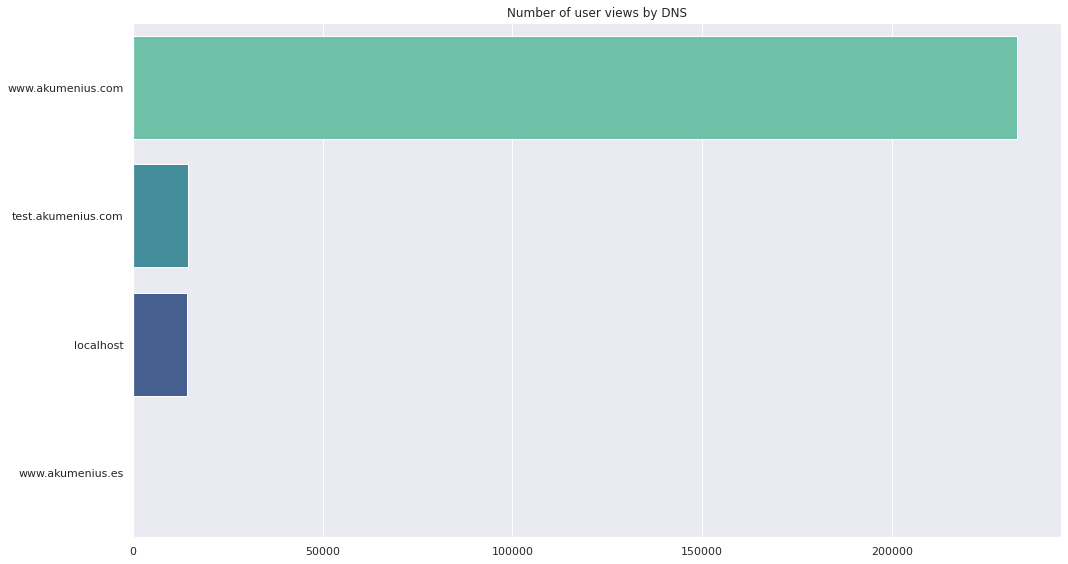

In [111]:
fig, ax1 = plt.subplots(figsize=(15, 8),sharex=True,tight_layout=True)

dns = sns.barplot(data=Logs_copy2.groupby('DNS')[['IP']].count().sort_values(by='IP',ascending=False).reset_index().head(10),
                    y='DNS',  
                    x='IP',
                    palette='mako_r',
                    ax=ax1)

dns.set(title='Number of user views by DNS',
          ylabel=None,
          xlabel=None)

- Number of user views by Country

[Text(0.5, 1.0, 'Number of user views by country'),
 Text(0, 0.5, ''),
 Text(0.5, 0, '')]

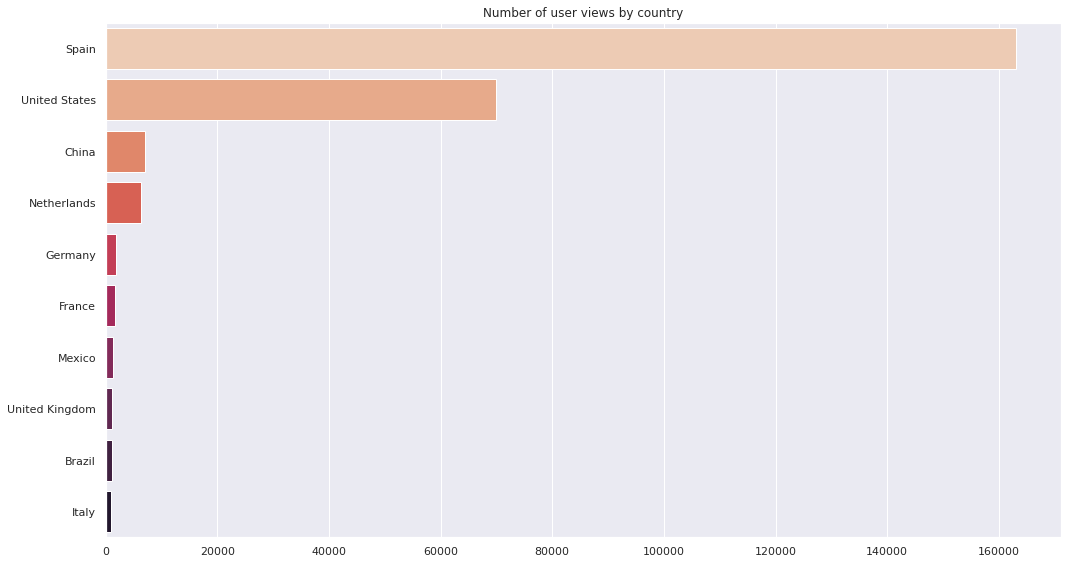

In [112]:
fig, ax1 = plt.subplots(figsize=(15, 8),sharex=True,tight_layout=True)

country = sns.barplot(data=Logs_copy2.groupby('COUNTRY_NAME')[['IP']].count().sort_values(by='IP',ascending=False).reset_index().head(10),
                    y='COUNTRY_NAME',  
                    x='IP',
                    palette='rocket_r',
                    ax=ax1)

country.set(title='Number of user views by country',
          ylabel=None,
          xlabel=None)

- Number of user views by City

[Text(0.5, 1.0, 'Number of user views by City'),
 Text(0, 0.5, ''),
 Text(0.5, 0, '')]

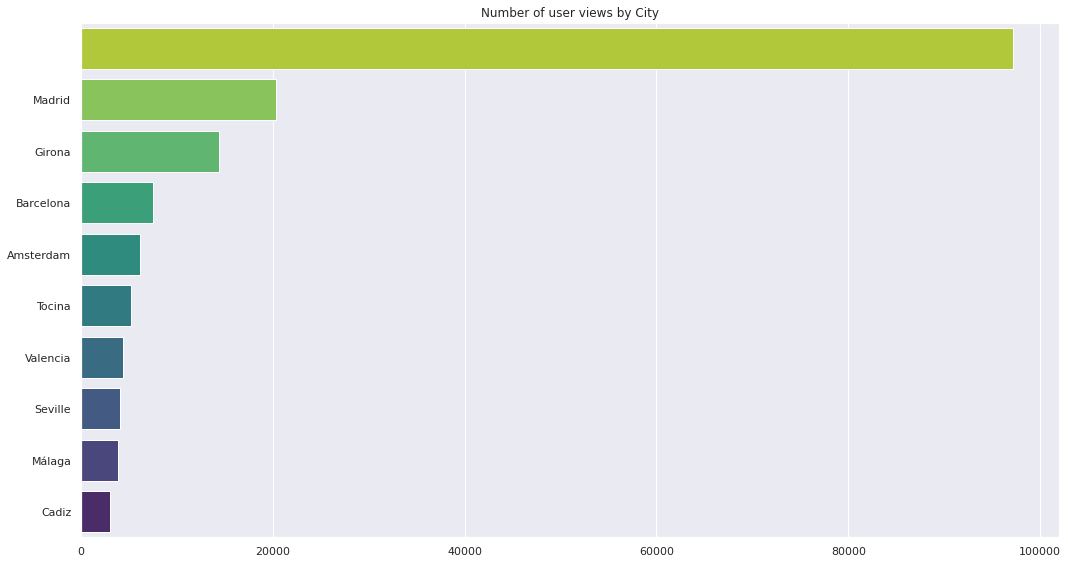

In [113]:
fig, ax1 = plt.subplots(figsize=(15, 8),sharex=True,tight_layout=True)

city = sns.barplot(data=Logs_copy2.groupby('CITY')[['IP']].count().sort_values(by='IP',ascending=False).reset_index().head(10),
                    y='CITY',  
                    x='IP',
                    palette='viridis_r',
                    ax=ax1)

city.set(title='Number of user views by City',
          ylabel=None,
          xlabel=None)

- Number of user views by Request

[Text(0.5, 1.0, 'Number of user views by Request'),
 Text(0, 0.5, ''),
 Text(0.5, 0, '')]

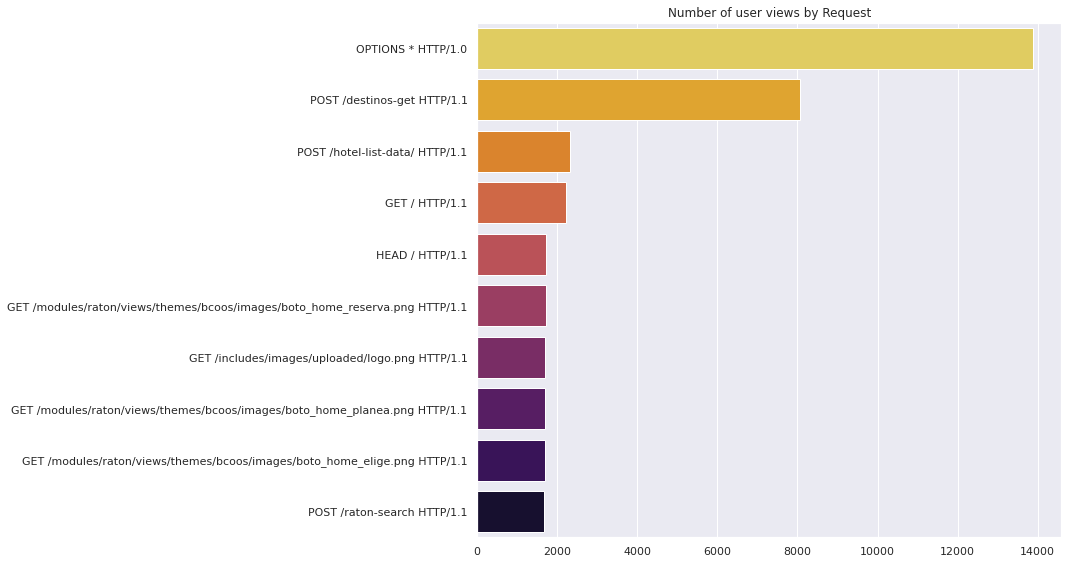

In [114]:
fig, ax1 = plt.subplots(figsize=(15, 8),sharex=True,tight_layout=True)

city = sns.barplot(data=Logs_copy2.groupby('REQUEST')[['IP']].count().sort_values(by='IP',ascending=False).reset_index().head(10),
                    y='REQUEST',  
                    x='IP',
                    palette='inferno_r',
                    ax=ax1)

city.set(title='Number of user views by Request',
          ylabel=None,
          xlabel=None)

- Number of user views by Referer

[Text(0.5, 1.0, 'Number of user views by Referer'),
 Text(0, 0.5, ''),
 Text(0.5, 0, '')]

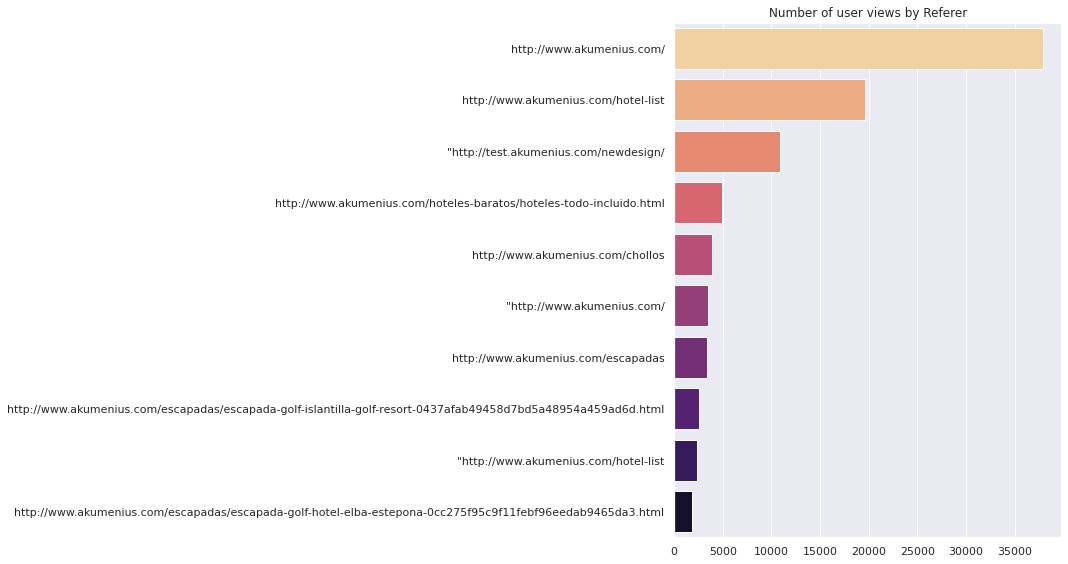

In [115]:
fig, ax1 = plt.subplots(figsize=(15, 8),sharex=True,tight_layout=True)

city = sns.barplot(data=Logs_copy2.groupby('REFERER')[['IP']].count().sort_values(by='IP',ascending=False).reset_index().head(10),
                    y='REFERER',  
                    x='IP',
                    palette='magma_r',
                    ax=ax1)

city.set(title='Number of user views by Referer',
          ylabel=None,
          xlabel=None)

- views by Device and OS

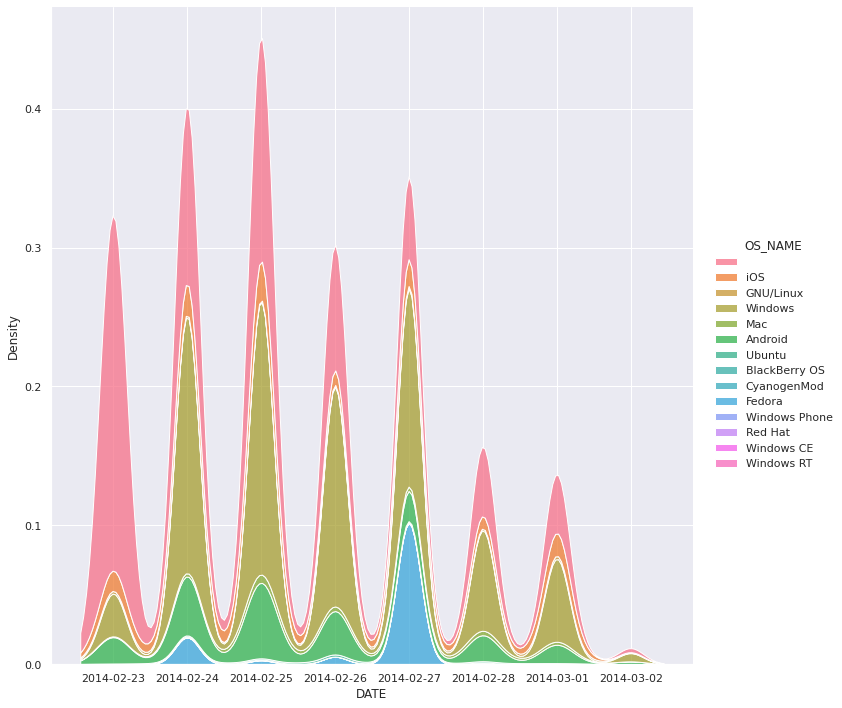

In [116]:

sns.displot(data = Logs_copy2, x = "DATE", hue = "OS_NAME", multiple="stack", kind="kde", height=10)

- Status by number of views

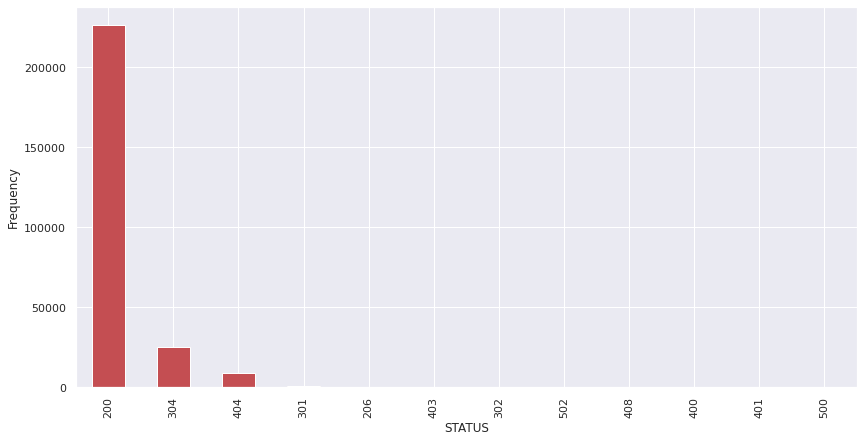

In [117]:
graph = Logs_copy2[['STATUS', 'DNS']].groupby(['STATUS']).count().sort_values(by = 'DNS',ascending = False)
graph = graph.rename(columns = {'DNS' : 'Frequency'})
graph.plot.bar(y = 'Frequency', color = 'r', ylabel = 'Frequency', legend = None, figsize = (14,7))
plt.show()

- Views by Client Type

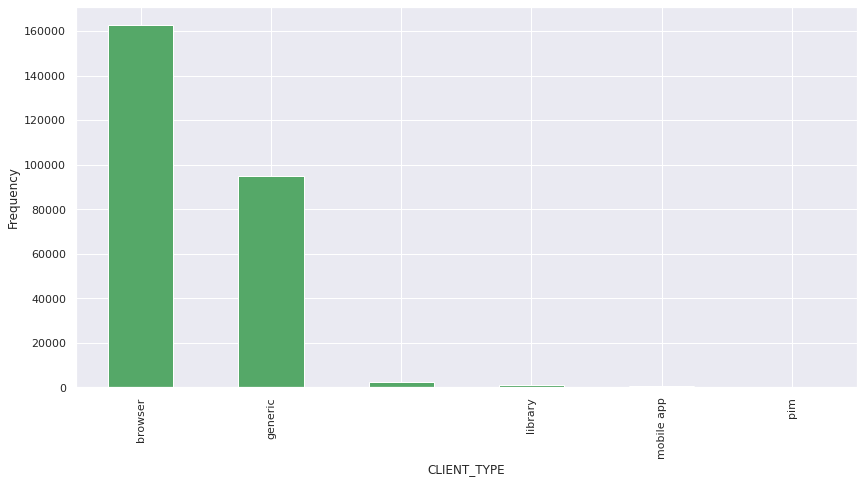

In [118]:
graph = Logs_copy2[['CLIENT_TYPE', 'DNS']].groupby(['CLIENT_TYPE']).count().sort_values(by = 'DNS',ascending = False)
graph = graph.rename(columns = {'DNS' : 'Frequency'})
graph.plot.bar(y = 'Frequency', color = 'g', ylabel = 'Frequency', legend = None, figsize = (14,7))
plt.show()

- Device type for DNS

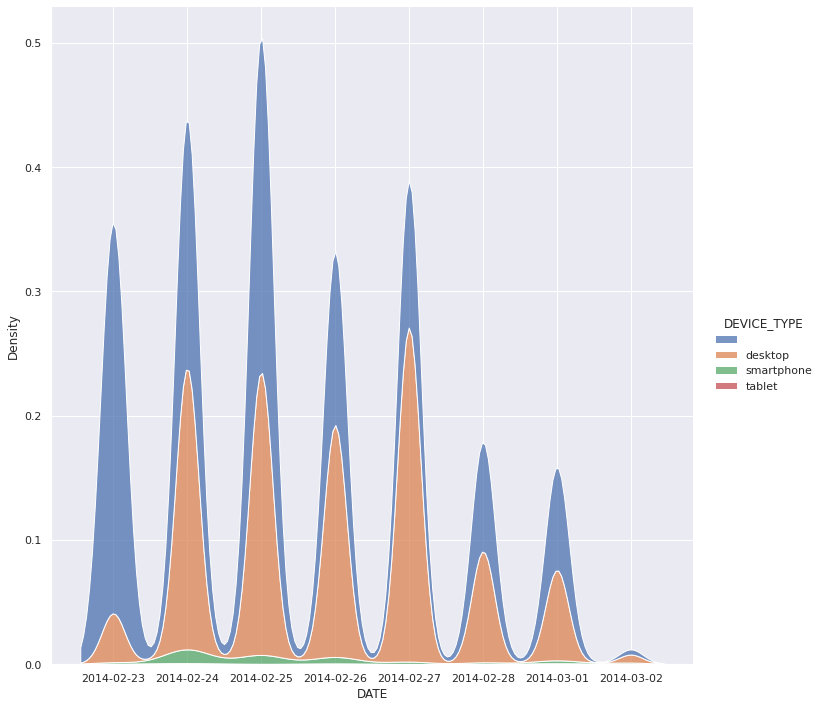

In [119]:
sns.set(rc={"figure.figsize": (20, 10)})
sns.displot(data = Logs_copy2, x = "DATE", hue = "DEVICE_TYPE", multiple = "stack", kind="kde", height=10)

- Geolocations

In [120]:
GEOLOCATIONS = Logs_copy2[Logs_copy2['LONGITUDE'] != " "][['CITY','COUNTRY_NAME', 'LONGITUDE', 'LATITUDE']].astype({'LONGITUDE': float,'LATITUDE': float})
GEOLOCATIONS = (GEOLOCATIONS[['CITY', 'COUNTRY_NAME', 'LONGITUDE', 'LATITUDE']].groupby('CITY').agg({'LONGITUDE' : np.mean, 'LATITUDE': np.mean}))

GEOLOCATIONS.info()

<class 'pandas.core.frame.DataFrame'>
Index: 718 entries,  to Úbeda
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   LONGITUDE  718 non-null    float64
 1   LATITUDE   718 non-null    float64
dtypes: float64(2)
memory usage: 16.8+ KB


- Geolocations of web Views

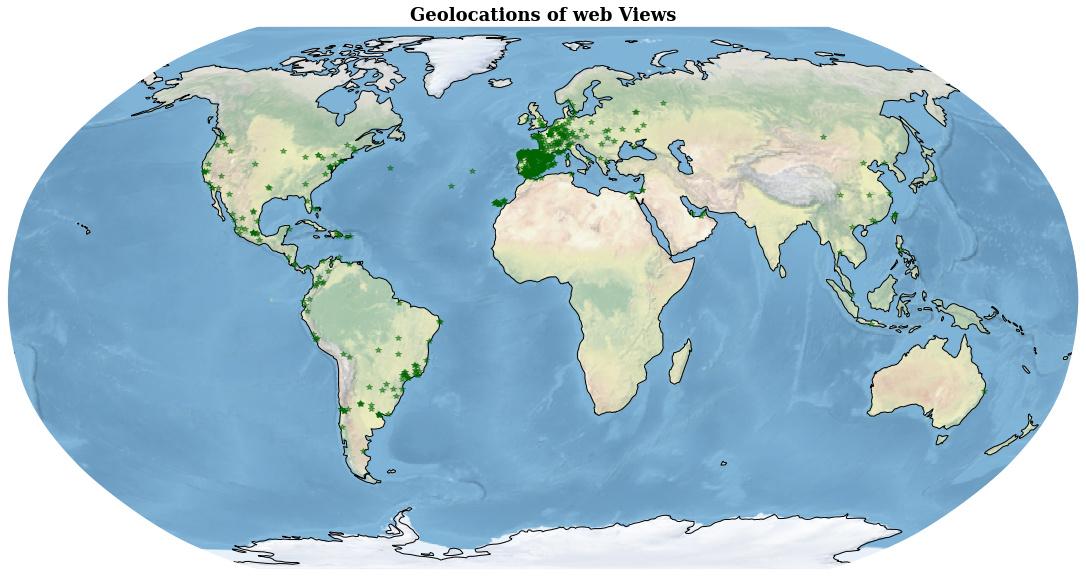

In [121]:
def main():
    fig = plt.figure(figsize=(20, 10))
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson())
    
    ax.set_global()

    ax.stock_img()
    ax.coastlines()
   
    ax.plot(GEOLOCATIONS.LONGITUDE, GEOLOCATIONS.LATITUDE, '*', alpha= 0.5, transform=ccrs.PlateCarree(), color='darkgreen')

    plt.title('Geolocations of web Views',fontdict={'family': 'serif', 
                    'color' : 'black',
                    'weight': 'bold',
                    'size': 18})
    plt.show()


if __name__ == '__main__':
    main()


- Geolocations with Plotly 

In [122]:
df_sample = Logs_copy2.where(Logs_copy2.DNS == 'www.akumenius.com').sample(n=1000, random_state=1)

fig = px.scatter_geo(df_sample, 
                    lat=df_sample.LATITUDE,
                    lon=df_sample.LONGITUDE,
                    hover_name=df_sample.CITY,
                    projection="equirectangular",
                    scope='world')
fig.update_layout({
        'height': 700,
        'width':1200,
    })

- I have used a random sample because it consumes too many resources to see the entire dataframe correctly

- Zone more density of Views to the web

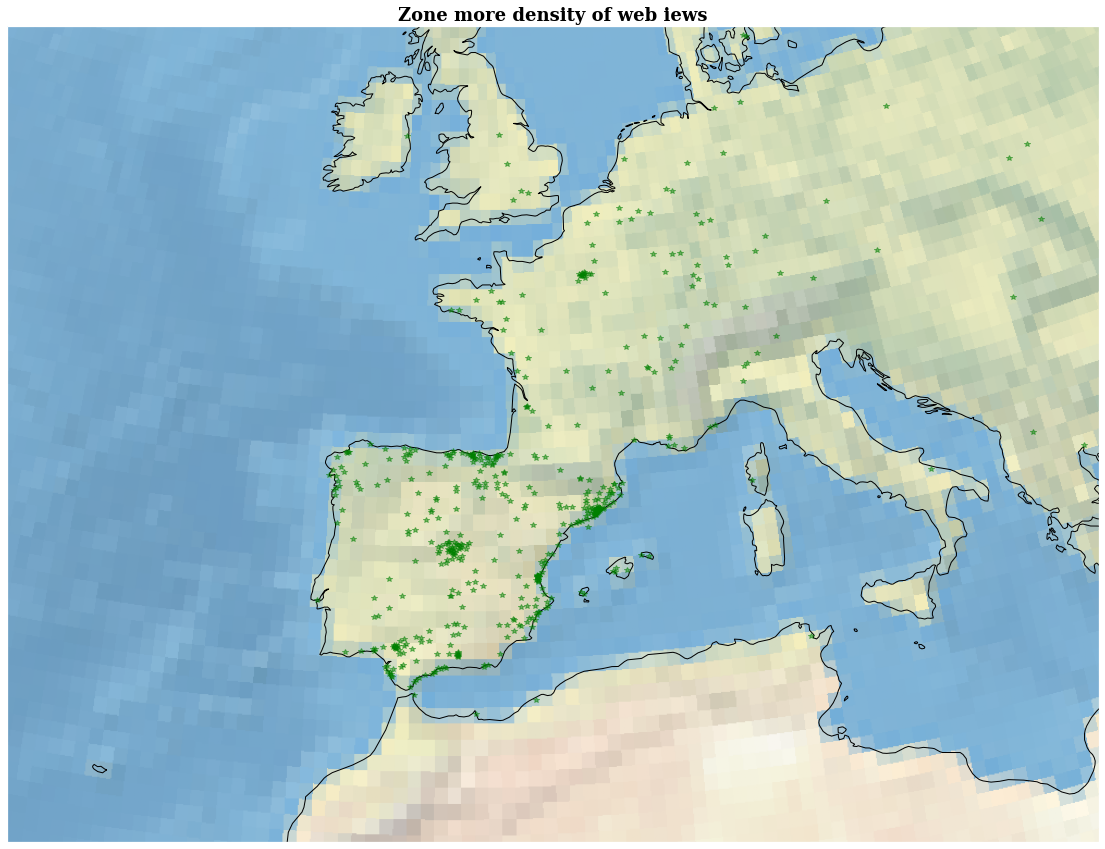

In [123]:
def main():
    fig = plt.figure(figsize=(30, 15))
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson())
    


    central_lon, central_lat = -3.7492, 40.4636
    extent = [-20, 20, 30, 55]
    ax = plt.axes(projection=ccrs.Orthographic(central_lon, central_lat))
    ax.set_extent(extent)
    ax.stock_img()
    ax.coastlines(resolution='50m')
   
    ax.plot(GEOLOCATIONS.LONGITUDE, GEOLOCATIONS.LATITUDE, '*', alpha= 0.5, transform=ccrs.PlateCarree(), color='green')

    plt.title('Zone more density of web iews',fontdict={'family': 'serif', 
                    'color' : 'black',
                    'weight': 'bold',
                    'size': 18})
    plt.show()


if __name__ == '__main__':
    main()

- More density with Plotly

In [124]:
fig = px.scatter_geo(df_sample, lat=df_sample.LATITUDE,
                    lon=df_sample.LONGITUDE,
                    hover_name=df_sample.CITY,       
                    projection="equirectangular",
                    scope='europe')
fig.update_layout({
        'height': 800,
        'width':1200,
    })

- I have used a random sample because it consumes too many resources to see the entire dataframe correctly

- Save the data obtained for later reuse

In [125]:
Logs_export = Logs_copy2.copy()

Logs_export.replace('', 'null', inplace = True)

Logs_export.to_csv('data/Logs_export.csv', index = False)

- Preparing data for the Dash App

In [126]:
Logs_export = Logs_export.sample(n=10000, random_state=1)
Logs_export.replace('', 'null', inplace = True)
Logs_export.to_csv('data/Logs-App.csv', index = False)

## Build Dashboard In Python – Plotly Dash 
### Dash is a Python framework, based on Flask, Plotly and ReactJS

### New environment for the project v0.1  

- mkdir Web-Log-Dash-App && cd Web-Log-Dash-App
- python3 -m venv
- source venv/bin/activate

- pip install dash pandas
- pip install plotly
- pip install gunicorn

### Create app.py Dashboard

- Import dependencies  

- Styles CSS  

  - Sidebar
  - Content 
  - Text
  - Cards  

- Build Controls  

- Sidebar Component  

- Content Components  

- Initialize Application  

- callbacks interactive figures 

### .gitignore  
- venv
- *.pyc
- .DS_Store
- .env


### Procfile  
- web: gunicorn app:server

### requirements.txt  
- pip freeze > requeriments.txt

### Run Application  

- python app.py

### [Web Log Dash App Github Repo](https://github.com/jesussantana/Web-Log-Dash-App)
### [Web Log Dash App Deploy](https://web-log-dashboard.herokuapp.com/)

### Dash App Preview

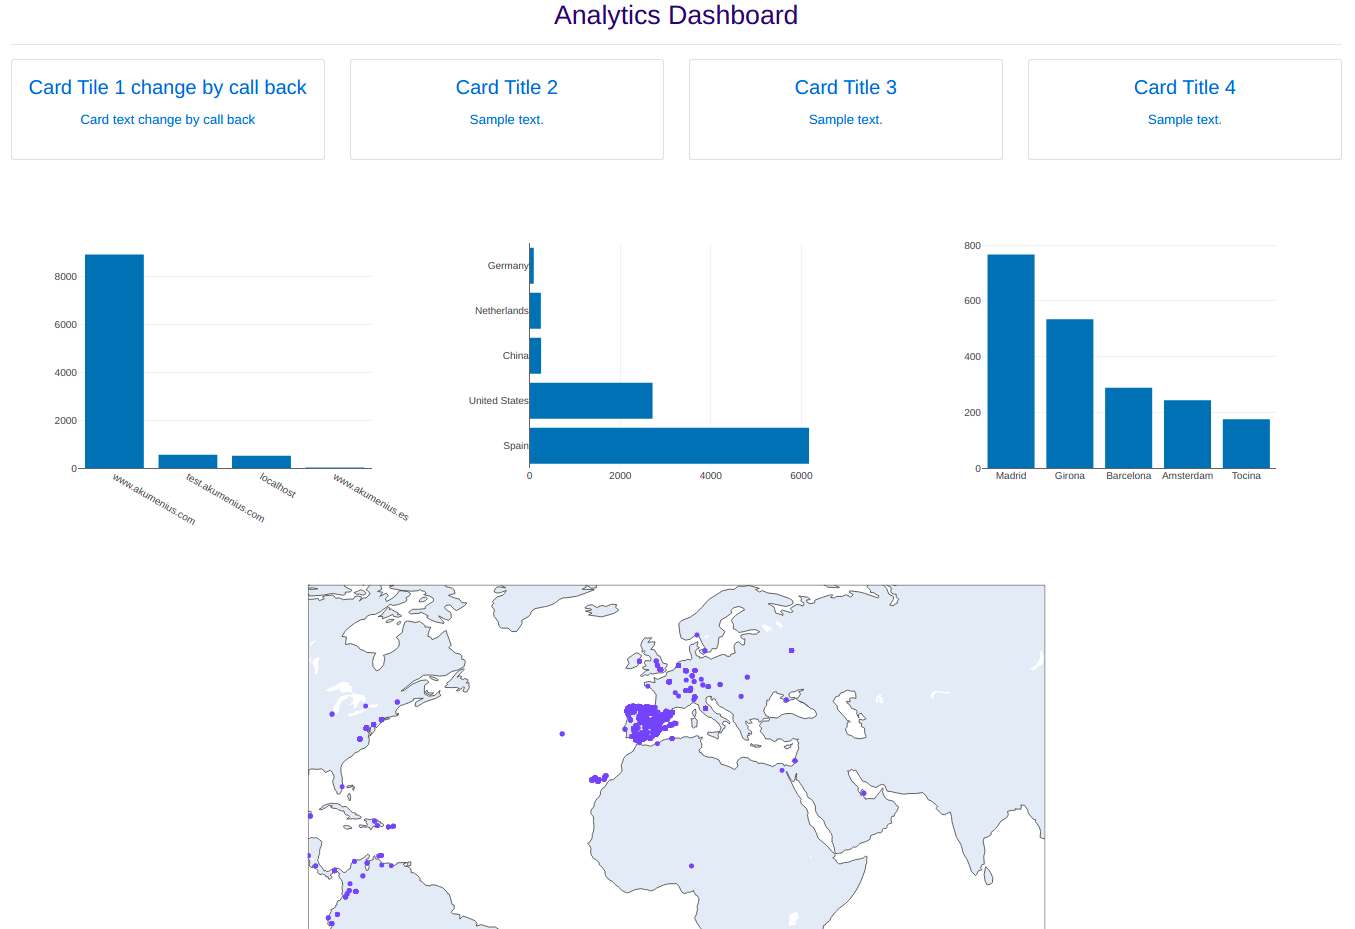

In [127]:
from IPython.display import Image
Image(filename='data/Web-Log-Dash-App-Preview.png')